# Youtube Spam Comment Classification using classical ML techniques


The data set was taken from UCI Machine Learning Repo
It is a public set of comments collected for spam research. It has five datasets composed by 1,956 real messages extracted from five videos that were among the 10 most viewed on the collection period.

Alberto, T. & Lochter, J. (2015). YouTube Spam Collection [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C58885.

## 1. Load libraries

In [239]:
#Import the necessary libraries
import pandas as pd
import numpy as np
import scipy as sp
import sys, re, bs4, nltk, sklearn, matplotlib
from bs4 import BeautifulSoup
import datasets, transformers 
from copy import deepcopy
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download("stopwords")
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score,classification_report,accuracy_score,recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ashutosh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ashutosh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Ashutosh\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ashutosh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Get data

In [1]:
pip install ucimlrepo


[notice] A new release of pip is available: 23.1.2 -> 25.1
[notice] To update, run: C:\Users\Ashutosh\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [86]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
youtube_spam_collection = fetch_ucirepo(id=380) 
  
# data (as pandas dataframes) 
X = youtube_spam_collection.data.features 
y = youtube_spam_collection.data.targets 
  
# metadata 
print(youtube_spam_collection.metadata) 
  
# variable information 
print(youtube_spam_collection.variables) 


{'uci_id': 380, 'name': 'YouTube Spam Collection', 'repository_url': 'https://archive.ics.uci.edu/dataset/380/youtube+spam+collection', 'data_url': 'https://archive.ics.uci.edu/static/public/380/data.csv', 'abstract': 'It is a public set of comments collected for spam research. It has five datasets composed by 1,956 real messages extracted from five videos that were among the 10 most viewed on the collection period.', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Text'], 'num_instances': 1956, 'num_features': 3, 'feature_types': [], 'demographics': [], 'target_col': ['CLASS'], 'index_col': ['VIDEO', 'COMMENT_ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2015, 'last_updated': 'Wed Apr 03 2024', 'dataset_doi': '10.24432/C58885', 'creators': ['T.C. Alberto', 'J.V. Lochter'], 'intro_paper': None, 'additional_info': {'summary': 'The table below lists the datasets, the YouTube video ID, the amount of samples in ea

## 3. Methodology

We will prepeocess the data, tokenize, clean it (stemming, lemmization), encode it (bag of words, tf-idf), then use multiple methodes to classify it and compare resutls

    ```Input data
    pre-processing
        A --> Toeknization
        B --> Stemming/Lemmization
        C --> Encoding (Bag of Words, TF-IDF)
    Modelling
        D --> Model creation
        E --> Model validation

In [3]:
for i in X['CONTENT'][0:20]:
    print(i)

Huh, anyway check out this you[tube] channel: kobyoshi02
Hey guys check out my new channel and our first vid THIS IS US THE  MONKEYS!!! I'm the monkey in the white shirt,please leave a like comment  and please subscribe!!!!
just for test I have to say murdev.com
me shaking my sexy ass on my channel enjoy ^_^ ﻿
watch?v=vtaRGgvGtWQ   Check this out .﻿
Hey, check out my new website!! This site is about kids stuff. kidsmediausa  . com
Subscribe to my channel ﻿
i turned it on mute as soon is i came on i just wanted to check the  views...﻿
You should check my channel for Funny VIDEOS!!﻿
and u should.d check my channel and tell me what I should do next!﻿
Hey subscribe to me﻿
 Once you have started reading do not stop. If you do not subscribe to me  within one day you and you're entire family will die so if you want to stay  alive subscribe right now.﻿
https://twitter.com/GBphotographyGB﻿
subscribe like comment﻿
please like :D https://premium.easypromosapp.com/voteme/19924/616375350﻿
Hello! Do

## 4. Data Cleaning

In [104]:
# We want to remove URL as comment as it will confuse the model but we will keep a flag that a url watch present here, 
#as it might be a strong indicator of a spam comment

X_all = [re.sub(r'http\S+|www\S+|https\S+', 'url', i, flags=re.MULTILINE) for i in X['CONTENT']]

# Similarly for watch, we will remove complext suffix but keep the word watch as an input to out model
X_all = [re.sub(r'watch\?v=\S+', 'watch', i, flags=re.MULTILINE) for i in X_all]

# Remove any html tags by mistake
X_all = [BeautifulSoup(i, "html.parser").get_text() for i in X_all]

# for any emoji or emoticon replace it with the word "emoji" as it can be a useful feature
X_all = [re.sub("[:;][)|(DP]","emoji",i) for i in X_all]

# any number does not look like year should be replaced with an identifier number

def not_number(string):
    string = re.sub(",","",string)
    try:
        float(string)
        return False
    except ValueError:
        return True
    
def check_range(string_no):
    string_no = re.sub(",","",string_no)
    if(float(string_no) <= 2100.0 and float(string_no) >= 1800.0):
        return(True)
    else:
        return(False)

def remove_suprious_num(snt):
    token_words = word_tokenize(snt)
    changed_words = [i if not_number(i) else "year" if  check_range(i) else "largenumber" for i in token_words]
    return(" ".join(changed_words))

X_all = [remove_suprious_num(i) for i in X_all]

# convert all to lower case
X_all = [i.casefold() for i in X_all]

# romve extra white space 
X_all = [re.sub(r'[^\w\s]', '', i) for i in X_all]

X_all = [re.sub(r'\s+', ' ', i).strip() for i in X_all]



C:\Users\Ashutosh\AppData\Local\Temp\ipykernel_20180\313952684.py:10: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  X_all = [BeautifulSoup(i, "html.parser").get_text() for i in X_all]


## 4. Split into test and train data

In [106]:
# Let us check the distirbution of labels, if it is highly imbalanced
y.value_counts()

CLASS
1        1005
0         951
Name: count, dtype: int64

The labels seem to be very well balanced, hence we need not worry about sampling techniques (oversampling/undersampling/smote,etc).

In [107]:
# we will use y to stratify so the distribution of labels is simialr in training and test data
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=42, stratify=y)

Let us check the distribution in training and test data

In [108]:
print(y_train.value_counts())
print(y_test.value_counts())

CLASS
1        804
0        760
Name: count, dtype: int64
CLASS
1        201
0        191
Name: count, dtype: int64


## 5. Pre-processing and tokenization

### 5a. Remove stop words

In [110]:
print(stopwords)
stop_words = set(stopwords.words("english"))
stop_words

<WordListCorpusReader in 'C:\\Users\\Ashutosh\\AppData\\Roaming\\nltk_data\\corpora\\stopwords'>


{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [111]:
def remove_stop_words(sent):
    token_words = word_tokenize(sent)
    clean_token_words = [i for i in token_words if i not in stop_words]
    return(" ".join(clean_token_words))

In [113]:
X_train = [remove_stop_words(i) for i in X_train]
X_test = [remove_stop_words(i) for i in X_test]
X_train[0:10]

['video largenumber views largenumber million people earth',
 'head like largenumber years ago time flies',
 'largenumber billions year',
 'wtf subscribe channel thanx',
 'omg',
 'please become first subscriber thank',
 'everyone come check new gta largenumber gameplay right watch v6_h0m5sayho',
 'remember back popular everyone school shuffling crazy',
 'url url largenumber please halp project',
 'haha funny see salt westerners top views youtube goes video dont even understand keep salt']

### 5b. Normalization - Lemmization

In [115]:
def normalize_data(sent,lemmitizer):
    token_words = word_tokenize(sent)
    clean_tokens = [lemmitizer.lemmatize(i) for i in token_words]
    return(" ".join(clean_tokens)) 

lemmitizer = WordNetLemmatizer()
X_train = [normalize_data(i,lemmitizer) for i in X_train]
X_test = [normalize_data(i,lemmitizer) for i in X_test]
X_train[0:20]

['video largenumber view largenumber million people earth',
 'head like largenumber year ago time fly',
 'largenumber billion year',
 'wtf subscribe channel thanx',
 'omg',
 'please become first subscriber thank',
 'everyone come check new gta largenumber gameplay right watch v6_h0m5sayho',
 'remember back popular everyone school shuffling crazy',
 'url url largenumber please halp project',
 'haha funny see salt westerner top view youtube go video dont even understand keep salt',
 'believe jesus christ savior sin truly believe jesus christ savior sin go heaven believe jesus christ saved salvation gained god righteousness matter much sinned past present especially future believe jesus christ savior go heaven forever whole truth spread truth',
 'music hero',
 'check berzerk video channel',
 'check app solve partydrunk problem br href url playgooglecomstoreappsdetails idvnibitapplocker amp hlen url playgooglecomstoreappsdetails idvnibitapplocker amp hlen',
 'love song make wan na dance',


## 6. Numberical Encoding

### 6a. Bag of words

In [134]:
vectorizer = CountVectorizer()

# fit bag of words training data
train_bow = vectorizer.fit_transform(X_train)
train_bow_ary = train_bow.toarray()

# fit bag of words test data
test_bow = vectorizer.transform(X_test)
test_bow_ary = test_bow.toarray()

In [135]:
# Shape of array of bow
print(train_bow.toarray().shape)
print(test_bow.toarray().shape)

(1564, 3168)
(392, 3168)


In [131]:
# No of sentences in training data 
len(X_train)

1564

In [132]:
# Vocab size
len(vectorizer.vocabulary_)

3168

### 6B. TF-IDF 

In [141]:
tfidf = TfidfVectorizer()

# fit data to tfidf
train_tfidf = tfidf.fit_transform(X_train)
test_tfidf = tfidf.transform(X_test)


In [143]:
# array shape
print(train_tfidf.toarray().shape)
print(test_tfidf.shape)

(1564, 3168)
(392, 3168)


In [147]:
# vocab
print(len(tfidf.vocabulary_))

3168


## 7. SPAM Classification

### 7a. Naive Bayes Model

In [190]:
#################################################
#
# Using bag of words
#################################################

# Initialize classifier, fit, and predict
nb_classifier_bow = MultinomialNB()
nb_classifier_bow.fit(train_bow_ary, np.array(y_train).ravel())
bow_nb_prediction_train = nb_classifier_bow.predict(train_bow_ary)
bow_nb_prediction_test = nb_classifier_bow.predict(test_bow_ary)


In [220]:
# Training accuracy
bow_nb_train_accuracy = accuracy_score(y_train, bow_nb_prediction_train)
# Testing accuracy
bow_nb_test_accuracy = accuracy_score(y_test, bow_nb_prediction_test)

bow_nb_train_precision = precision_score(y_train, bow_nb_prediction_train)
bow_nb_test_precision = precision_score(y_test, bow_nb_prediction_test)

bow_nb_train_recall = recall_score(y_train, bow_nb_prediction_train)
bow_nb_test_recall = recall_score(y_test, bow_nb_prediction_test)

print("training accuracy is {0}".format(round(bow_nb_train_accuracy,3)))
print("test accuracy is {0}".format(round(bow_nb_test_accuracy,3)))

print("training precision is {0}".format(round(bow_nb_train_precision,3)))
print("test precision is {0}".format(round(bow_nb_test_precision,3)))

training accuracy is 0.957
test accuracy is 0.893
training precision is 0.951
test precision is 0.86


#### Prior and Posterior Prob

In [186]:
print("Log prior probabilities", nb_classifier_bow.class_log_prior_)
print("Log likelihoods (log P(x_i | C_k)):",nb_classifier_bow.feature_log_prob_)

Log prior probabilities [-0.72168349 -0.66540265]
Log likelihoods (log P(x_i | C_k)): [[-8.17145819 -8.17145819 -8.86460537 ... -8.17145819 -8.17145819
  -8.86460537]
 [-9.51222116 -9.51222116 -8.81907398 ... -9.51222116 -9.51222116
  -8.81907398]]


In [187]:
#################################################
#
# Using tfidf
#################################################

nb_classifier_tfidf = MultinomialNB()
nb_classifier_tfidf.fit(train_tfidf, np.array(y_train).ravel())

tfidf_nb_prediction_train = nb_classifier_tfidf.predict(train_tfidf)
tfidf_nb_prediction_test = nb_classifier_tfidf.predict(test_tfidf)


In [221]:
# Training accuracy
tfidf_nb_train_accuracy = accuracy_score(y_train, tfidf_nb_prediction_train)
# Testing accuracy
tfidf_nb_test_accuracy = accuracy_score(y_test, tfidf_nb_prediction_test)

tfidf_nb_train_precision = precision_score(y_train, tfidf_nb_prediction_train)
tfidf_nb_test_precision = precision_score(y_test, tfidf_nb_prediction_test)

tfidf_nb_train_recall = recall_score(y_train, tfidf_nb_prediction_train)
tfidf_nb_test_recall = recall_score(y_test, tfidf_nb_prediction_test)

print("training accuracy is {0}".format(round(tfidf_nb_train_accuracy,3)))
print("test accuracy is {0}".format(round(tfidf_nb_test_accuracy,3)))

print("training precision is {0}".format(round(tfidf_nb_train_precision,3)))
print("test precision is {0}".format(round(tfidf_nb_test_precision,3)))

training accuracy is 0.971
test accuracy is 0.901
training precision is 0.967
test precision is 0.872


## 7b. Logistic Regression Model

In [202]:
#################################################
#
# Using bag of words
#################################################

# Initialize classifier, fit, and predict
logit_classifier_bow = LogisticRegression()
logit_classifier_bow.fit(train_bow_ary, np.array(y_train).ravel())
bow_logit_prediction_train = logit_classifier_bow.predict(train_bow_ary)
bow_logit_prediction_test = logit_classifier_bow.predict(test_bow_ary)



In [223]:
# Training accuracy
bow_logit_train_accuracy = accuracy_score(y_train, bow_logit_prediction_train)
# Testing accuracy
bow_logit_test_accuracy = accuracy_score(y_test, bow_logit_prediction_test)

bow_logit_train_precision = precision_score(y_train, bow_logit_prediction_train)
bow_logit_test_precision = precision_score(y_test, bow_logit_prediction_test)

bow_logit_train_recall = recall_score(y_train, bow_logit_prediction_train)
bow_logit_test_recall = recall_score(y_test, bow_logit_prediction_test)

print("training accuracy is {0}".format(round(bow_logit_train_accuracy,3)))
print("test accuracy is {0}".format(round(bow_logit_test_accuracy,3)))

print("training precision is {0}".format(round(bow_logit_train_precision,3)))
print("test precision is {0}".format(round(bow_logit_test_precision,3)))

print(classification_report(y_test, bow_logit_prediction_test))

training accuracy is 0.985
test accuracy is 0.939
training precision is 0.994
test precision is 0.949
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       191
           1       0.95      0.93      0.94       201

    accuracy                           0.94       392
   macro avg       0.94      0.94      0.94       392
weighted avg       0.94      0.94      0.94       392



In [205]:
#################################################
#
# Using tfidf
#################################################

# Initialize classifier, fit, and predict
logit_classifier_tfidf = LogisticRegression()
logit_classifier_tfidf.fit(train_bow_ary, np.array(y_train).ravel())
tfidf_logit_prediction_train = logit_classifier_tfidf.predict(train_tfidf)
tfidf_logit_prediction_test = logit_classifier_tfidf.predict(test_tfidf)



In [222]:
# Training accuracy
tfidf_logit_train_accuracy = accuracy_score(y_train, tfidf_logit_prediction_train)
# Testing accuracy
tfidf_logit_test_accuracy = accuracy_score(y_test, tfidf_logit_prediction_test)

tfidf_logit_train_precision = precision_score(y_train, tfidf_logit_prediction_train)
tfidf_logit_test_precision = precision_score(y_test, tfidf_logit_prediction_test)

tfidf_logit_train_recall = recall_score(y_train, tfidf_logit_prediction_train)
tfidf_logit_test_recall = recall_score(y_test, tfidf_logit_prediction_test)

print("training accuracy is {0}".format(round(tfidf_logit_train_accuracy,3)))
print("test accuracy is {0}".format(round(tfidf_logit_test_accuracy,3)))

print("training precision is {0}".format(round(tfidf_logit_train_precision,3)))
print("test precision is {0}".format(round(tfidf_logit_test_precision,3)))

print(classification_report(y_test, tfidf_logit_prediction_test))

training accuracy is 0.648
test accuracy is 0.673
training precision is 1.0
test precision is 1.0
              precision    recall  f1-score   support

           0       0.60      1.00      0.75       191
           1       1.00      0.36      0.53       201

    accuracy                           0.67       392
   macro avg       0.80      0.68      0.64       392
weighted avg       0.80      0.67      0.64       392



### 7c. Support Vector Machines

In [211]:
#################################################
#
# Using bag of words
#################################################

# Initialize classifier, fit, and predict
svm_classifier_bow = SVC(kernel='rbf', random_state=1234)
svm_classifier_bow.fit(train_bow_ary, np.array(y_train).ravel())
bow_svm_prediction_train = svm_classifier_bow.predict(train_bow_ary)
bow_svm_prediction_test = svm_classifier_bow.predict(test_bow_ary)



In [224]:
# Training accuracy
bow_svm_train_accuracy = accuracy_score(y_train, bow_svm_prediction_train)
# Testing accuracy
bow_svm_test_accuracy = accuracy_score(y_test, bow_svm_prediction_test)

bow_svm_train_precision = precision_score(y_train, bow_svm_prediction_train)
bow_svm_test_precision = precision_score(y_test, bow_svm_prediction_test)

bow_svm_train_recall = recall_score(y_train, bow_svm_prediction_train)
bow_svm_test_recall = recall_score(y_test, bow_svm_prediction_test)

print("training accuracy is {0}".format(round(bow_svm_train_accuracy,3)))
print("test accuracy is {0}".format(round(bow_svm_test_accuracy,3)))

print("training precision is {0}".format(round(bow_svm_train_precision,3)))
print("test precision is {0}".format(round(bow_svm_test_precision,3)))

print(classification_report(y_test, bow_svm_prediction_test))

training accuracy is 0.969
test accuracy is 0.926
training precision is 0.992
test precision is 0.943
              precision    recall  f1-score   support

           0       0.91      0.94      0.93       191
           1       0.94      0.91      0.93       201

    accuracy                           0.93       392
   macro avg       0.93      0.93      0.93       392
weighted avg       0.93      0.93      0.93       392



In [217]:
#################################################
#
# Using tfidf
#################################################

# Initialize classifier, fit, and predict
svm_classifier_tfidf = SVC()
svm_classifier_tfidf.fit(train_tfidf, np.array(y_train).ravel())
tfidf_svm_prediction_train = svm_classifier_tfidf.predict(train_tfidf)
tfidf_svm_prediction_test = svm_classifier_tfidf.predict(test_tfidf)



In [225]:
# Training accuracy
tfidf_svm_train_accuracy = accuracy_score(y_train, tfidf_svm_prediction_train)
# Testing accuracy
tfidf_svm_test_accuracy = accuracy_score(y_test, tfidf_svm_prediction_test)

tfidf_svm_train_precision = precision_score(y_train, tfidf_svm_prediction_train)
tfidf_svm_test_precision = precision_score(y_test, tfidf_svm_prediction_test)

tfidf_svm_train_recall = recall_score(y_train, tfidf_svm_prediction_train)
tfidf_svm_test_recall = recall_score(y_test, tfidf_svm_prediction_test)

print("training accuracy is {0}".format(round(tfidf_svm_train_accuracy,3)))
print("test accuracy is {0}".format(round(tfidf_svm_test_accuracy,3)))

print("training precision is {0}".format(round(tfidf_svm_train_precision,3)))
print("test precision is {0}".format(round(tfidf_svm_test_precision,3)))

print(classification_report(y_test, tfidf_svm_prediction_test))

training accuracy is 0.997
test accuracy is 0.936
training precision is 0.995
test precision is 0.936
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       191
           1       0.94      0.94      0.94       201

    accuracy                           0.94       392
   macro avg       0.94      0.94      0.94       392
weighted avg       0.94      0.94      0.94       392



## 8. Comparing results

In [241]:
compare_results_training = pd.DataFrame({"precision":[bow_nb_train_precision, tfidf_nb_train_precision,
                            bow_logit_train_precision, tfidf_logit_train_precision,
                            bow_svm_train_precision, tfidf_svm_train_precision],
                  "recall":[bow_nb_train_recall, tfidf_nb_train_recall,
                            bow_logit_train_recall, tfidf_logit_train_recall,
                            bow_svm_train_recall, tfidf_svm_train_recall],
                  "label": ["NB BOW","NB TF_IDF","Logit BOW","Logit TF_IDF","SVM BOW","SVM TF_IDF"]})

In [237]:
compare_results_test = pd.DataFrame({"precision":[bow_nb_test_precision, tfidf_nb_test_precision,
                            bow_logit_test_precision, tfidf_logit_test_precision,
                            bow_svm_test_precision, tfidf_svm_test_precision],
                  "recall":[bow_nb_test_recall, tfidf_nb_test_recall,
                            bow_logit_test_recall, tfidf_logit_test_recall,
                            bow_svm_test_recall, tfidf_svm_test_recall],
                  "label": ["NB BOW","NB TF_IDF","Logit BOW","Logit TF_IDF","SVM BOW","SVM TF_IDF"]})

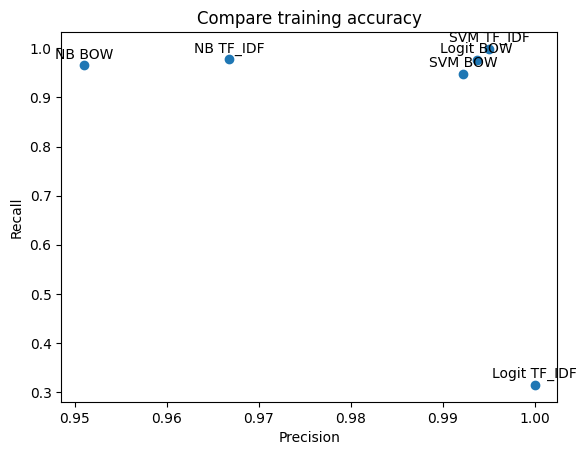

In [248]:
plt.figure()
plt.scatter(x = compare_results_training['precision'],y = compare_results_training['recall'])
plt.xlabel("Precision")
plt.ylabel("Recall")
for i in range(compare_results_training.shape[0]):
    plt.annotate(compare_results_training.loc[i,'label'],(compare_results_training.loc[i,'precision'],compare_results_training.loc[i,'recall']), textcoords="offset points", xytext=(0,5), ha='center')
plt.title("Compare training accuracy")
#plt.savefig("./Comapring_train_accuracy_spam_classifier_by_ml.png", bbox_inches = "tight")
plt.show()
plt.close()

Text(0.5, 1.0, 'Compare test accuracy')

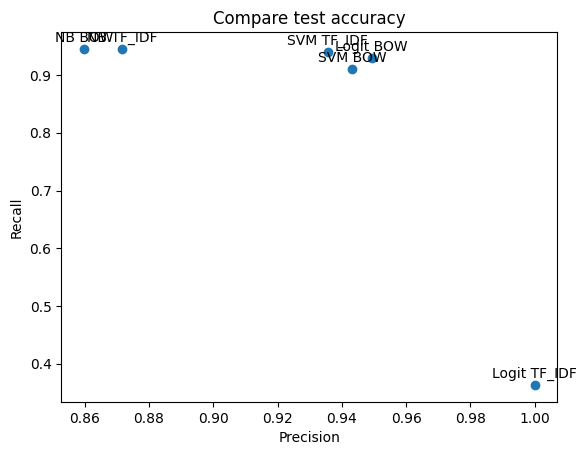

In [249]:
plt.figure()
plt.scatter(x = compare_results_test['precision'],y = compare_results_test['recall'])
plt.xlabel("Precision")
plt.ylabel("Recall")
for i in range(compare_results_test.shape[0]):
    plt.annotate(compare_results_test.loc[i,'label'],(compare_results_test.loc[i,'precision'],compare_results_test.loc[i,'recall']), textcoords="offset points", xytext=(0,5), ha='center')
plt.title("Compare test accuracy")

### Analysis of results


* Logit presision is comparable to rest but recall is very poor for TFIDF. But for BOW, it is comparable. This might have to do with the fact that BOW is kind of a simple count of words which might do well with a linearity of logistic model. However it has such a low recall in TF-IDF means it is not learning the probabilistic interpretation of TF-IDF and only guessing very conservatively. Maybe playing around thresholds can improve the accuracy.

* Naive Bayes performs worse with BOW in terms of precision then TF-IDF. This might be due to Naive Bayes being probabilistic doing better with a probabilistic interpretaiton of TF-IDF compared to count in BOW

* SVM performs equally good on both BOW and TF-IDF and has least overfitting due to inbuilt regularization. Logistic BOW also has least overfitting due to simplicity of model

<b>Conclusion : </b> If the encoding paradigm of text matches that of the ML model's approach to data, the resuts are much better than when they are not supplementary.